# AQI indexing and false imagery

### Author: Olivia Holt

#### githib link: https://github.com/olleholt/eds220-hw4-task3

### Purpose
To visualize the impact on the Air Quality Index Thomas Fire in Santa Barbara County and to create a false color image showing the fire scar of the Thomas fire in 2017.

### Highlights of analysis:
- Data wrangling and exploration
- Geospatial data wrangling
- Creating a plot for AQI through 2017
- Creating and customizing a map

### Dataset description

**Dataset 1**

Air Quality Index (AQI) data from the US Environmental Protection Agency.

**Dataset 2**

A simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite.

This data was accessed and pre-processed in the Microsoft Planetary Computer to remove data outside land and coarsen the spatial resolution (Landsat Collection in MPC). Data should be used for visualization purposes only.

**Dataset 3**

A shapefile of fire perimeters in California during 2017. The complete file can be accessed in the CA state geoportal.

### References to datasets:
AirNow. (2021b). Air Quality Index (AQI) Basics. Retrieved from www.airnow.gov website: https://www.airnow.gov/aqi/aqi-basics/

Wikipedia Contributors. (2019, October 6). Thomas Fire. Retrieved from Wikipedia website: https://en.wikipedia.org/wiki/Thomas_Fire

California Fire Perimeters (all). (n.d.). Retrieved November 29, 2023, from gis.data.ca.gov website: https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about

Microsoft Planetary Computer. Planetary Computer. (n.d.). https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)) 

## Importing libraries

In [1]:
#importing libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # for creating legends

import xarray as xr
import rioxarray as rioxr
import geopandas as gpd

from rasterio.features import rasterize #for rasterizing polygons
from shapely.geometry import box
from shapely.geometry import Point

## Import Data

In [2]:
#read in aqi 2017 data
aqi_17 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip")

#read in aqi 2018 data
aqi_18 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip")

# importing california fire perimeter data
ca = gpd.read_file('data/California_Fire_Perimeters_2017.shp')

#reading in the .nc file
landcover_fp = os.path.join(os.getcwd(),'data','landsat8-2018-01-26-sb-simplified.nc')
landcover = rioxr.open_rasterio(landcover_fp)

## Data exploration

In [3]:
# looking at the head of the data
ca.head()

#looking at the shape
ca.shape

#looking at the head of the data
landcover.head()

#looking at the shape of landcover
landcover.rio.shape

#looking at the dimensions of the landcover data
landcover.dims

#view first 5 columns of aqi 2017 data
aqi_17.head()

#view first 5 columns of aqi 2018 data
aqi_18.head()

#view columns of aqi 2017 data
aqi_17.columns

Index(['State Name', 'county Name', 'State Code', 'County Code', 'Date', 'AQI',
       'Category', 'Defining Parameter', 'Defining Site',
       'Number of Sites Reporting'],
      dtype='object')

## Cleaning/organizing

In [4]:
#combine both data sets into one dataset unsing concat
aqi = pd.concat([aqi_17,aqi_18])

# re-assign the column names - .str.lower() makes them lower case
aqi.columns = aqi.columns.str.lower()

#  re-assign the column names again - .str.replace(' ','_') replaces the space for _
aqi.columns = aqi.columns.str.replace(' ','_')

In [5]:
#dropping the bands to make a 2d data set in order to plot it
landcover = landcover.squeeze().drop('band')

# checking to see if the crs's match
ca.crs == landcover.rio.crs

#set landcover crs to ca crs, crs='EPSG:3857'
ca = ca.to_crs(landcover.rio.crs)

## Analysis

In [6]:
#selecting rows that equal 'santa barbara' in the county_name column
aqi_sb = aqi[aqi['county_name'] == 'Santa Barbara']

#removing the four specified columns
aqi_sb = aqi_sb.drop(columns = ['state_name','county_name','state_code', 'county_code'])

# covert aqi_sb.DATE column to timedate objects
pd.to_datetime(aqi_sb.date)

# convert DATE column from string to timestamps
aqi_sb.date = pd.to_datetime(aqi_sb.date)

#update the index tp the date column
aqi_sb = aqi_sb.set_index(aqi_sb.date)

# and we get a pd.Series as ouput
aqi_sb.aqi.rolling('5D').mean()

#adding a new column named 'five_day_average' into the aqi_sb dataframe
#finding the mean of the AQI over a 5 day rolling window and inputting those values into the new column
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean()

In [7]:
#selecting the thomas fire from the california fire 2017 dataset
thomas_fire = ca[ca['FIRE_NAME'] == 'THOMAS']

## Final Plotting

<AxesSubplot:title={'center':'AQI vs 5 Day Averages'}, xlabel='date'>

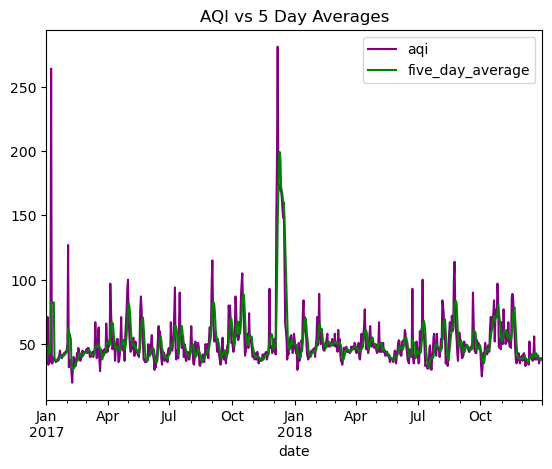

In [8]:
#plotting the AQI and the rolling averaged AQI over 5 days against eachother
aqi_sb.plot(y= ['aqi','five_day_average'], title='AQI vs 5 Day Averages', color = ['purple', 'green'] )

Text(0.5, 1.0, 'Thomas Fire in Santa Barbara County')

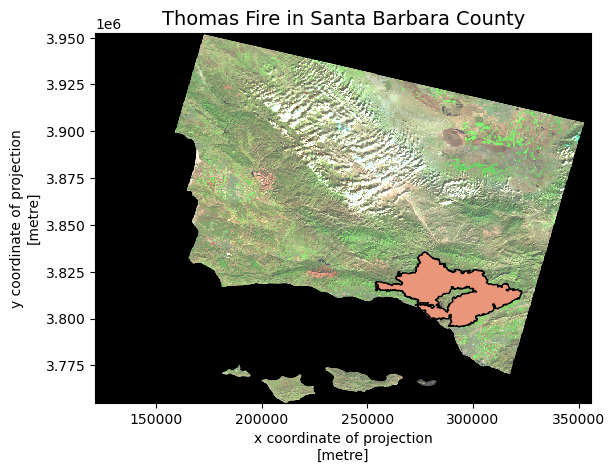

In [9]:
# setting up a plot
fig, ax = plt.subplots()

# plotting the thomas fire on top of the landover plot
thomas_fire.plot(ax=ax,
                color = "darksalmon",
                edgecolor= "black")
landcover[['swir22','nir08','red']].to_array().plot.imshow(robust = True)  #landcover plot

#setting the title name
ax.set_title('Thomas Fire in Santa Barbara County',  fontsize=14)